In [47]:
pip install threadpoolctl==3.1.0

In [48]:
%pip install tensorflow==2.12.0

In [49]:
%pip install munch
%pip install torch-geometric

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%cd /content/drive/MyDrive/THESIS_Prog/ER_GAT-main (1)/ER_GAT-main

/content/drive/MyDrive/THESIS_Prog/ER_GAT-main (1)/ER_GAT-main


In [52]:
%pwd

'/content/drive/MyDrive/THESIS_Prog/ER_GAT-main (1)/ER_GAT-main'

In [53]:
from sklearn.cluster import KMeans
import seaborn as sns
import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.io as pio
from sklearn.utils import class_weight
import tqdm as notebook_tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
from graph_context_dataset import FeatureEngineeredDataset
import warnings
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scipy.stats import norm
import random
from model import FCClassifier, DATASET_PATH
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

# Define Paths to pickle files

In [55]:
# Define paths to pickle files
cnn_pickle_path = f"data/dump/{dataset_path}/CNNBiLSTM_data_for_classifier/results/classifier_test_no_tuning_Df.pkl"
bert_pickle_path = f"data/dump/{dataset_path}/BERT_data_for_classifier/results/classifier_test_no_tuning_Df.pkl"

checkFile = os.path.isfile(cnn_pickle_path)
checkFile = os.path.isfile(bert_pickle_path)

# Load BERT and CNN data

In [56]:
# Load CNN data
with open(cnn_pickle_path, 'rb') as f:
    cnn_data = pd.read_pickle(f)

# Load BERT data
with open(bert_pickle_path, 'rb') as f:
    bert_data = pd.read_pickle(f)

# Convert dictionaries to DataFrames
cnn_df = pd.DataFrame.from_dict(cnn_data)
bert_df = pd.DataFrame.from_dict(bert_data)


# Cosine Similarity of BERT vs CNN

In [57]:
def sample_and_cosine_similarity(data1, data2, sample_size=3000):
    # Sample from data1 and data2
    sampled_data1 = data1.sample(n=min(sample_size, len(data1)), random_state=42)
    sampled_data2 = data2.sample(n=min(sample_size, len(data2)), random_state=42)

    sampled_data1 = sampled_data1.drop(columns=['data_combination', 'typeSet','isSimpleFC'])
    sampled_data2 = sampled_data2.drop(columns=['data_combination', 'typeSet','isSimpleFC'])

    # Drop NaN values if any
    sampled_data1 = sampled_data1.dropna()
    sampled_data2 = sampled_data2.dropna()

    # Calculate cosine similarity
    similarities = cosine_similarity(sampled_data1, sampled_data2)
    mean_similarity = np.mean(similarities)
    return mean_similarity

In [58]:
# Example for BERT EGAT vs CNN EGAT
bert_egat = bert_df[bert_df['data_combination'].str.contains('egat', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('egat', case=False)]
mean_similarity_u = sample_and_cosine_similarity(bert_egat, cnn_egat)
print("Mean Cosine Similarity (BERT EGAT vs CNN EGAT):", mean_similarity_u)

Mean Cosine Similarity (BERT EGAT vs CNN EGAT): 0.9887676154641903


In [59]:
# Example for BERT-RGAT vs CNN-RGAT
bert_egat = bert_df[bert_df['data_combination'].str.contains('rgat', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('rgat', case=False)]
mean_similarity_u = sample_and_cosine_similarity(bert_egat, cnn_egat)
print("Mean Cosine Similarity (BERT RGAT vs CNN RGAT):", mean_similarity_u)

Mean Cosine Similarity (BERT RGAT vs CNN RGAT): 0.9941380230724436


In [60]:
# Example for BERT-DGCN vs CNN-DGCN
bert_egat = bert_df[bert_df['data_combination'].str.contains('dgcn', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('dgcn', case=False)]
mean_similarity_u = sample_and_cosine_similarity(bert_egat, cnn_egat)
print("Mean Cosine Similarity (BERT DGCN vs CNN DGCN):", mean_similarity_u)

Mean Cosine Similarity (BERT DGCN vs CNN DGCN): 0.9937233809639829


# VARIANCE/Bell Curve for BERT and CNN

In [61]:
def plot_bell_curve(data, title):
    data = data.drop(columns=['data_combination', 'typeSet','isSimpleFC'])
    variance = np.var(data, axis=0)
    std_dev = np.sqrt(variance)
    mean = np.mean(data, axis=0)

    # Plotting
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
    plt.plot(x, norm.pdf(x, mean, std_dev))
    plt.title(f'Bell Curve for {title}')
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.show()

    return variance

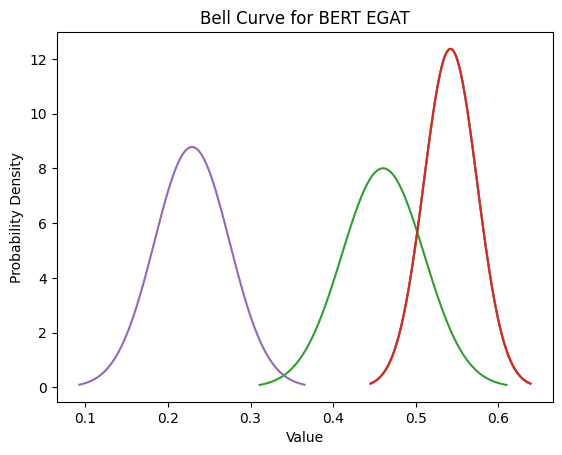

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


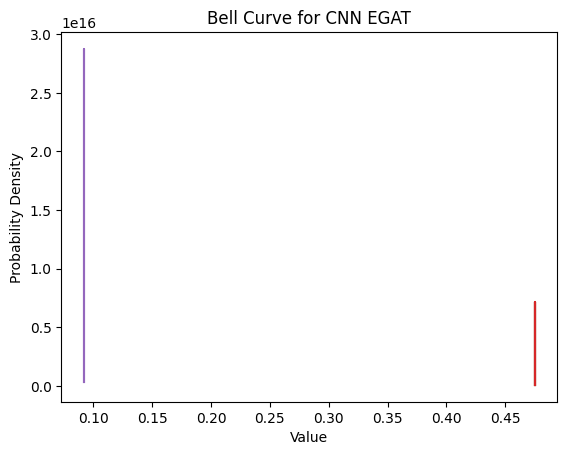

In [62]:
# Example for BERT EGAT vs CNN EGAT
bert_egat = bert_df[bert_df['data_combination'].str.contains('egat', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('egat', case=False)]
variance_bert_egat = plot_bell_curve(bert_egat, 'BERT EGAT')
variance_bert_egat = plot_bell_curve(cnn_egat, 'CNN EGAT')

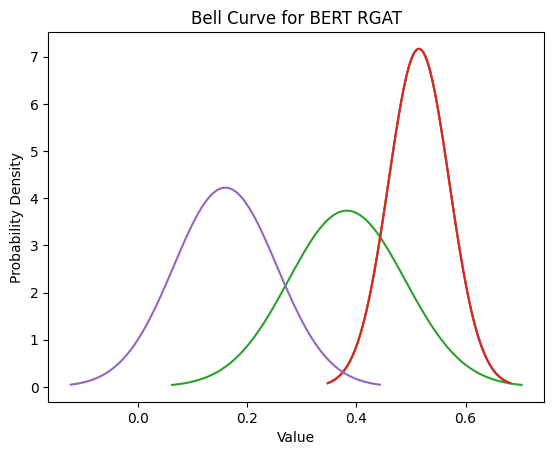

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


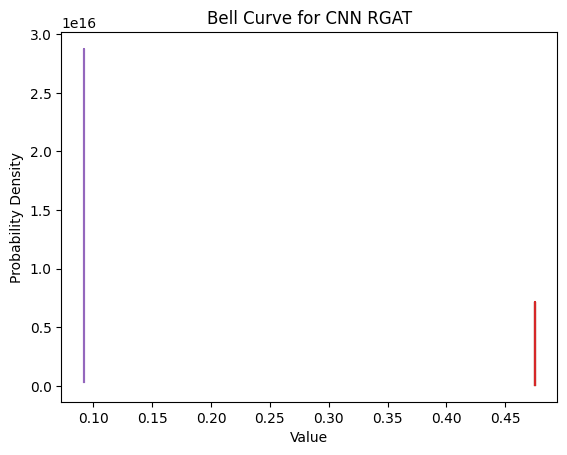

In [63]:
# Example for BERT-RGAT vs CNN-RGAT
bert_egat = bert_df[bert_df['data_combination'].str.contains('rgat', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('rgat', case=False)]
variance_bert_rgat = plot_bell_curve(bert_egat, 'BERT RGAT')
variance_bert_rgat = plot_bell_curve(cnn_egat, 'CNN RGAT')

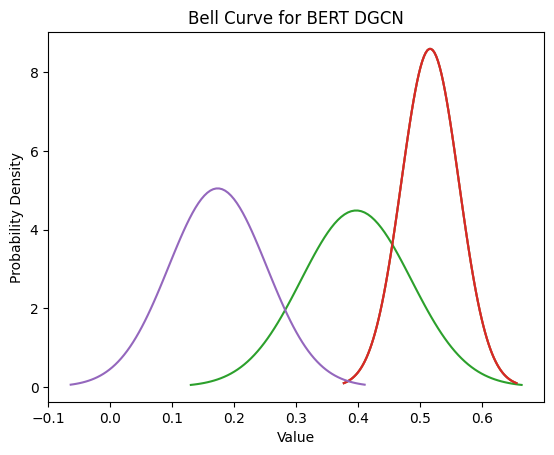

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


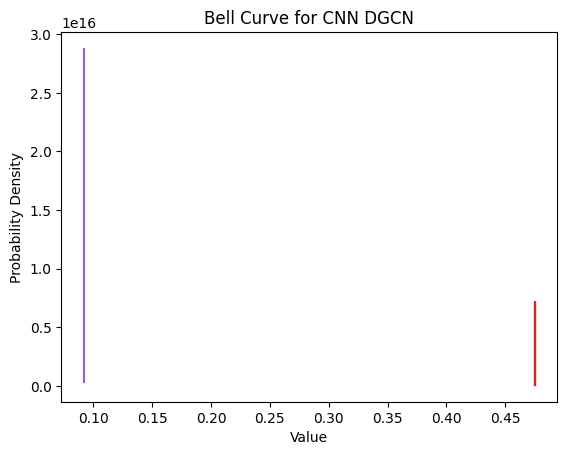

In [64]:
# Example for BERT-DGCN vs CNN-DGCN
bert_egat = bert_df[bert_df['data_combination'].str.contains('dgcn', case=False)]
cnn_egat = cnn_df[cnn_df['data_combination'].str.contains('dgcn', case=False)]
variance_bert_dgcn = plot_bell_curve(bert_egat, 'BERT DGCN')
variance_bert_dgcn = plot_bell_curve(cnn_egat, 'CNN DGCN')

# Performing TSNE(not done)

In [65]:

# Example for BERT
bert_tsne = bert_df.copy()
bert_tsne = bert_tsne.drop(columns=['data_combination', 'typeSet','isSimpleFC'])
# Example for CNN
cnn_tsne = cnn_df.copy()
cnn_tsne = cnn_tsne.drop(columns=['data_combination', 'typeSet','isSimpleFC'])

print(bert_tsne.shape,cnn_tsne.shape)

(44, 5) (44, 5)


In [66]:
n_components_bert = min(20, bert_tsne.shape[1], bert_tsne.shape[0])
n_components_cnn = min(10, cnn_tsne.shape[1], cnn_tsne.shape[0])

In [67]:
# Dimensionality reduction using PCA before applying t-SNE
pca = PCA(n_components=n_components_bert, random_state=42)
bert_pca = pca.fit_transform(bert_tsne)

In [68]:
pca = PCA(n_components=n_components_cnn, random_state=42)
cnn_pca = pca.fit_transform(cnn_tsne)

In [69]:
m = TSNE(n_components=2, learning_rate=50, random_state=42)

In [70]:
bert_tsne_features = m.fit_transform(bert_pca)

In [71]:
print(bert_tsne_features.shape)

(44, 2)


In [72]:
bert_tsne_df = pd.DataFrame(bert_tsne_features, columns=['x', 'y'])

In [73]:
bert_tsne_df1= bert_tsne_df.copy()
bert_tsne_df1['x'] = bert_tsne_features[:,0]
bert_tsne_df1['y'] = bert_tsne_features[:,1]

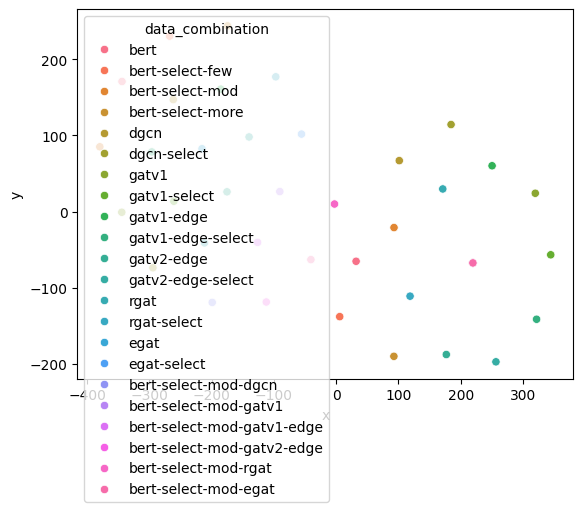

In [74]:
bert_labels = bert_df['data_combination']
sns.scatterplot(x='x',y='y',hue=bert_labels,data=bert_tsne_df1)
plt.show()

In [ ]:
cnn_tsne_features = m.fit_transform(cnn_pca)

In [ ]:
print(cnn_tsne_features.shape)

In [ ]:
#Kyle Lim: "Each time I run this cell, my kernel in anaconda got killed
cnn_tsne_df = pd.DataFrame(cnn_tsne_features,columns=['x','y'])

In [ ]:
cnn_tsne_df1= cnn_tsne_df.copy()
cnn_tsne_df1['x'] = cnn_tsne_features[:,0]
cnn_tsne_df1['y'] = cnn_tsne_features[:,1]

In [ ]:
cnn_labels = cnn_df['data_combination']
sns.scatterplot(x='x',y='y',hue=cnn_labels,data=cnn_tsne_df1)
plt.show()